<a href="https://colab.research.google.com/github/MaximeGloesener/HandsOnAI-Challenge1/blob/master/XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Hardware Informations (GPU)**

In [1]:
!/opt/bin/nvidia-smi
!rm -rf sample_data

Thu Nov 24 22:23:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **2. Importation of librairies**

In [2]:
!pip install tf-explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 819 kB/s 


In [3]:
from IPython.display import Image, HTML, display
from matplotlib import pyplot as plt
import numpy as np 
import os
import cv2
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception, preprocess_input, decode_predictions #299*299
from keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions #224*224
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import categorical_crossentropy
from keras.layers import Dense, GlobalAveragePooling2D, Activation, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import math
import argparse
import matplotlib
import imghdr
import pickle as pkl
import datetime
from cycler import cycler
from PIL import Image, ImageEnhance
from google.colab import files
from tqdm import tqdm
print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

Tensorflow version: 2.9.2
Keras version: 2.9.0


#**3. Connexion à Google Colab pour acceder aux bases de données**

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**5. Training parameters and selectioon of Pretrained model**

In [16]:
data_path= "gdrive/MyDrive/Challenge1" 
dataset_name='db1' #@param ["db1","db2"]
dataset_path = os.path.join(data_path,dataset_name)
input_dim = 224
nbr_batch_size = 32

#**14. Load model**


In [5]:
model = load_model('gdrive/MyDrive/Challenge1/test.h5')

In [17]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(os.path.join(data_path,'test_data/test/Test_Dataset')
	,          # chemin vers le jeu de données
	seed=42,                    # Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim,input_dim),       # Taille des images d'entrée
	batch_size=nbr_batch_size,      # Taille du mini-batch
  label_mode='categorical'    # Conversion au format One-Hot
)

Found 210 files belonging to 3 classes.


In [18]:
score = model.evaluate(test_ds,  steps=len(test_ds),workers = 1)
print("%s: %.2f%%" % (model.metrics_names[0], score[0]))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

7/7 [==============================] - 30s 249ms/step - loss: 0.1211 - accuracy: 0.9905
loss: 0.12%
accuracy: 99.05%


#**16. Test the model with a test image**

1/1 [==============================] - 1s 1s/step
Class Name : fire --- Class Probability: 100.00%
Class Name : no_fire --- Class Probability: 0.00%
Class Name : start_fire --- Class Probability: 0.00%


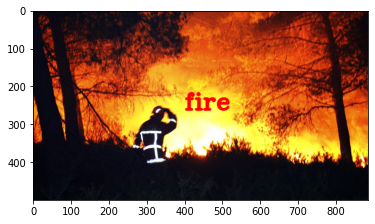

In [19]:
%matplotlib inline
classes = test_ds.class_names
image_path =  os.path.join(data_path,'test_data/Test_Dataset1/Test_Dataset/fire/test001.jpg')
img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)
# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

/usr/local/lib/python3.7/dist-packages/tf_explain/utils/display.py:112: RuntimeWarning: invalid value encountered in true_divide
  heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())


1/1 [==============================] - 0s 35ms/step


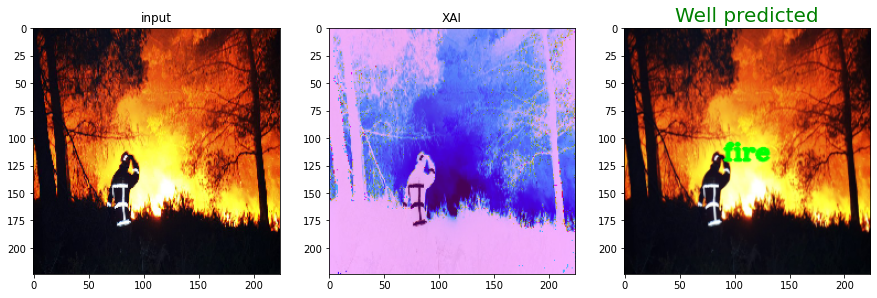

1/1 [==============================] - 0s 19ms/step


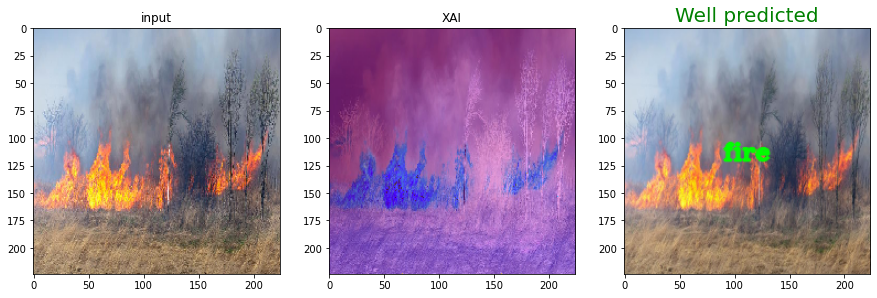

1/1 [==============================] - 0s 19ms/step


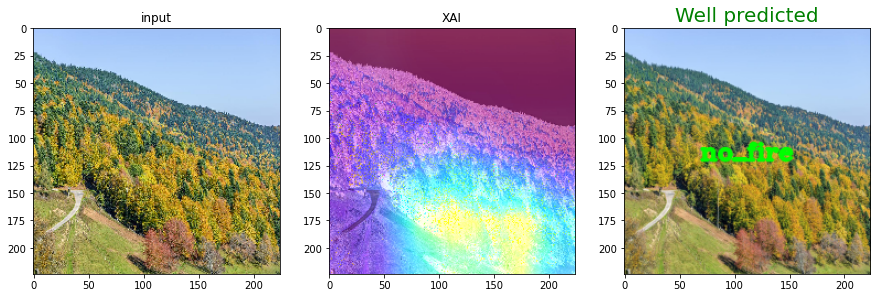

1/1 [==============================] - 0s 23ms/step


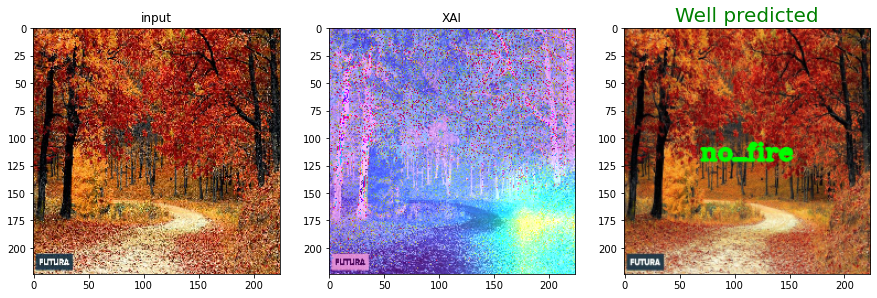

1/1 [==============================] - 0s 21ms/step


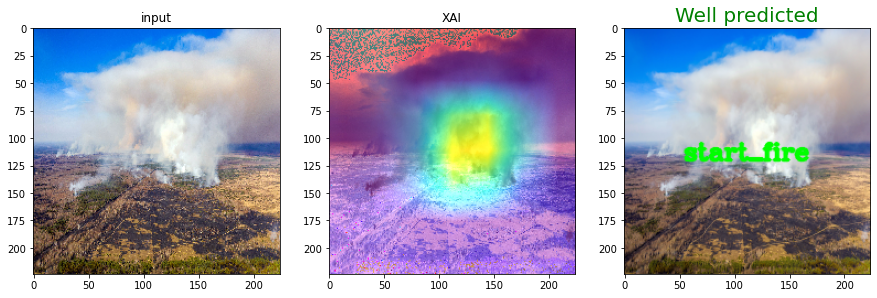

1/1 [==============================] - 0s 22ms/step


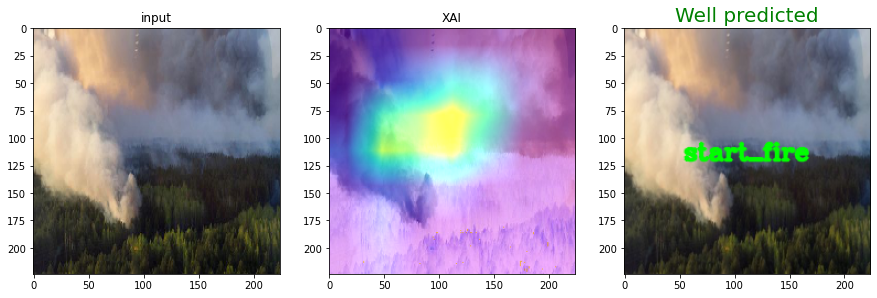

In [20]:
from tf_explain.core.grad_cam import GradCAM
from skimage import io

path_test = os.path.join(data_path,'test_data/test/Test_Dataset/')

for index, path in enumerate(['fire/', 'no_fire/', 'start_fire/']): 
  for img_path in os.listdir(path_test + path)[:2]:

      image_path = path_test + path + img_path
      className = path

      # Load to the correct format and predict the current image
      img_temp = tf.keras.preprocessing.image.load_img(image_path, target_size = (input_dim, input_dim))
      img = tf.keras.preprocessing.image.img_to_array(img_temp)

      data = ([img], None)
      xy = np.expand_dims(img, axis = 0)
      myTuple = (xy, None)

      explainer = GradCAM()
      grid = explainer.explain(myTuple, model, class_index = index)
      temp = np.concatenate((img,grid),axis=1)
      fig, axs = plt.subplots(1, 3)
      axs[0].imshow(img.astype(np.uint8))
      axs[0].set_title('input')
      axs[1].imshow(grid.astype(np.uint8))
      axs[1].set_title('XAI')

      fig.set_figheight(15)
      fig.set_figwidth(15)

      pred = model.predict(xy, batch_size = 1)[0]

      for (pos, prob) in enumerate(pred):

        class_name_predicted = classes[pos]

        if (pos == np.argmax(pred)):

            isCorrect = (class_name_predicted == className[:-1])

            img = cv2.imread(image_path)
            img = cv2.resize(img, (input_dim,input_dim), interpolation = cv2.INTER_AREA)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            font = cv2.FONT_HERSHEY_COMPLEX 
            textsize = cv2.getTextSize(class_name_predicted, font, 0.7, 2)[0]
            textX = (img.shape[1] - textsize[0]) / 2
            textY = (img.shape[0] + textsize[1]) / 2
            cv2.putText(img, class_name_predicted, (int(textX), int(textY)), font, 0.7, (0,255,0) if  isCorrect else (255,0,0), 2, cv2.LINE_AA)

            axs[2].imshow(img)
            title_text =  'Well predicted' if isCorrect else 'Wrong : ' + className
            title=axs[2].set_title(title_text, fontsize=20)
            plt.setp(title, color = 'g' if isCorrect else 'r') 

      plt.show()